## Chapter 14: Tree-based learners

# 14.1  From stumps to deep trees

In Section 11.1 we saw the simplest exemplar of a tree-based learner: the stump. In this Section we discuss how, using simple stumps, we can define general and more complex tree-based universal approximators in a recursive manner.

In [2]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
import autograd.numpy as np
from mlrefined_libraries import math_optimization_library as optlib

from mlrefined_libraries import nonlinear_superlearn_library as nonlib
datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'

static_plotter = optlib.static_plotter.Visualizer()
regress_plotter = nonlib.nonlinear_regression_demos


# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True
%matplotlib notebook

# plotting
import matplotlib.pyplot as plt
import copy

%load_ext autoreload
%autoreload 2

## The stump

The most basic tree-based universal approximator, the stump, defined as 

\begin{equation}
f\left(x\right)=\begin{cases}
\begin{array}{c}
v_{1}\\
v_{2}
\end{array} & \begin{array}{c}
x<s\\
x>s
\end{array}\end{cases}
\end{equation}

is a simple step function with three parameters: two step levels or *leaf* parameters denoted by $v_1$ and $v_2$ (whose values are set independently of one another), and a split point parameter $s$ defining the boundary between the two levels (see the left panel of Figure below). In the right panel of this Figure we show another graphical representation of Equation (1) which helps explain the particular nomenclature (tree, leaf, etc.) used in the context of tree-based approximators. Represented this way, the stump can be thought of as a binary tree structure of depth one with $f(x)$ as its root node, and $v_1$ and $v_2$ as its leaf nodes. Conceptually speaking there are two approaches to building more flexible (or *deeper*) trees using stumps, which we discuss next.      

<figure>
<p>
  <img src= '../../mlrefined_images/nonlinear_superlearn_images/tree_depth_1_2.png' width="85%" height="65%" alt=""/>
</p>
<figcaption> <strong>Figure 1:</strong> <em> 
(top left) A simple stump, defined in Equation (1), has three parameters: $v_1$, $v_2$, and $s$. (top right) An illustration of a stump function as a binary tree structure of depth one. (bottom panels) Recursive construction of depth two tree from a depth one tree. 
</em>
</figcaption>
</figure>

## Creating high capacity trees via recursion

The first approach to creating high capacity tree units entails *recursion* where each leaf of a depth one tree (a stump) is recursively split up into two new leaves, introducing two new split points and creating a total of four distinct leaves. This gives us a *tree of depth two* as illustrated in the bottom row of Figure above. Notice how a depth two tree has significantly greater capacity than its stump relative shown in the top row, since the location of the split points and values set to the levels can be set in a multitude of ways. 

Using recursion we can construct deeper trees in a similar manner. One can easily show that a tree of general depth $D$ will have $2^D-1$ split points and $2^D$ leaves, thus $2^{D+1}-1$ tunable parameters in total. The deeper a tree becomes the more capacity it gains, being able to take on a wider variety of shapes. For example, in Figure below we compare $4$ instances of a depth $D=2$ tree (top row) with $4$ instances of a depth $D=10$ tree (bottom row) where all parameters are set randomly. Note here that for visualization purposes the leaves of each tree are connected by vertical lines, which is commonly done when visualizing tree-based units.

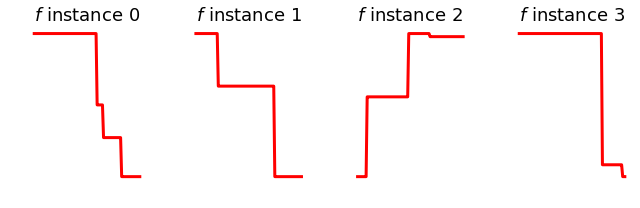

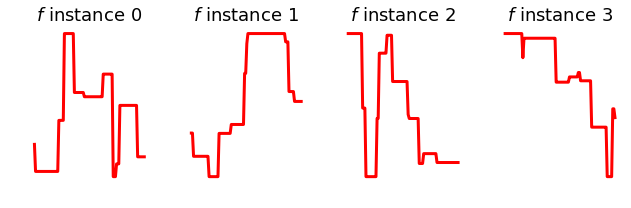

In [4]:
## This code cell will not be shown in the HTML version of this notebook
def build_stump(s,L1,L2,x):
    stump = []
    for pt in x:
        if pt < s:
            stump.append(L1)
        else:
            stump.append(L2)
    stump = np.array(stump).flatten()
    return stump

def build_random_tree(D):    
    # input space
    x = np.linspace(0,1,100)
    
    # build tree
    fm = np.zeros((100,1)).flatten()
    for d in range(D):
        # make stump element
        s = np.random.rand(1)
        L1 = np.random.randn(1)
        L2 = np.random.randn(1)
        new = build_stump(s,L1,L2,x)
        
        # add to current
        fm += new
    return fm

def plot_trees(D,num_instances):
    # figure
    fig = plt.figure(figsize = (9,3))
    x = np.linspace(0,1,100)

    # loop over and create instances
    for n in range(num_instances):
        # create tree 
        fm = build_random_tree(D)
        
        # plot the current element
        ax = fig.add_subplot(1,num_instances,n+1)
        ax.plot(x,fm,c='r',zorder = 3,linewidth = 3)
        ax.set_title('$f$ instance ' + str(n),fontsize = 18)

        # clean up plot
        ax.grid(True, which='both')
        #ax.axhline(y=0, color='k')
        #ax.axvline(x=0, color='k')
        ax.axis('off')
    plt.show()
    
# use plotting tool
D = 2
num_stumps = D + 1
num_instances = 4
plot_trees(num_stumps,num_instances)


# use plotting tool
D = 10
num_stumps = D + 1
num_instances = 4
plot_trees(num_stumps,num_instances)

## Creating high capacity trees via addition

Deeper, more flexible trees can also be constructed via *addition* of shallower trees in general, and stumps in particular. For instance, Figure 2 illustrates how a depth two tree can be made via addition of three depth one trees (stumps).

<figure>
<p>
  <img src= '../../mlrefined_images/nonlinear_superlearn_images/tree_addition.png' width="85%" height="65%" alt=""/>
</p>
<figcaption> <strong>Figure 2:</strong> <em> 
(left) Three stumps, each depicted in a distinct color. (right) A depth two tree (in black), made via addition of the three depth one trees shown in the left panel.
</em>
</figcaption>
</figure>

Although Equation (1) shows the most common way of parameterizing a simple stump, it is also possible to write a stump in a slightly different but equivalent way, replacing the leaf parameters with what can be interpreted as a bias and a weight, in a manner resembling what we have seen before with fixed-shape and neural network approximators. More specifically, the stump in Equation (1) can be written as

\begin{equation}
f(x) = b + w\,h(x)
\end{equation}


where $b$ represents the bias parameter, $w$ is the weight attached to $h(x)$, and $h$ itself is a step function with fixed levels and a split at $x=s$ 

\begin{equation}
h\left(x\right)=\begin{cases}
\begin{array}{c}
0 \\
1
\end{array} & \begin{array}{c}
x<s\\
x>s
\end{array}\end{cases}
\end{equation}
 
This alternative perspective is particularly is useful in the context of boosting as discussed previously in Chapter 11.